**Brian Blaylock**  
**August 8, 2019**  
brian.blaylock@utah.edu | [website](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/home.html)

# GOES-17: Day Snow-Fog RGB Recipe


| Additional Notebooks                                                                                                                             |
| -------------------------------------------------------------------------------------------------------------------------------------------------|
| [GOES16 Fire Temperature](<https://github.com/blaylockbk/pyBKB_v3/blob/master/BB_GOES/mapping_GOES16_FireTemperature.ipynb>)                     |
| [GOES16 Day Convection](<https://github.com/blaylockbk/pyBKB_v3/blob/master/BB_GOES/mapping_GOES16_DayConvection.ipynb>)                         |
| [GOES16 Air Mass](<https://github.com/blaylockbk/pyBKB_v3/blob/master/BB_GOES/mapping_GOES16_AirMass.ipynb>)                                     |
| [GOES16 Day Cloud Phase Distinction](<https://github.com/blaylockbk/pyBKB_v3/blob/master/BB_GOES/mapping_GOES16_DayCloudPhaseDistinction.ipynb>) |
| [GOES16 Water Vapor](<https://github.com/blaylockbk/pyBKB_v3/blob/master/BB_GOES/mapping_GOES16_WaterVapor.ipynb>)                               |

This Python 3 notebook shows how to make a **Day Snow-Fog RGB** image from the GOES-17
Advanced Baseline Imager (ABI) level 2 data. We will plot the image with
matplotlib and Cartopy. The methods shown here are stitched
together from the following useful information found online:

- [**Day Snow-Fog RGB Recipe**](http://rammb.cira.colostate.edu/training/visit/quick_guides/QuickGuide_DaySnowFog.pdf)
- [ABI Bands Quick Information Guides](https://www.goes-r.gov/education/ABI-bands-quick-info.html)
- [Open Commons Consortium](http://edc.occ-data.org/goes16/python/)
- [GeoNetCast Blog](https://geonetcast.wordpress.com/2017/07/25/geonetclass-manipulating-goes-16-data-with-python-part-vi/)
- [Proj documentation](https://proj4.org/operations/projections/geos.html?highlight=geostationary)
- [Pyproj documentation](http://jswhit.github.io/pyproj/pyproj.Proj-class.html)

The Day Snow-Fog product is a RGB composite of the following three channels:

|        --| Wavelength   | Channel | Description |
|----------|:------------:|:-------:|:-----------:|
| **Red**  | 0.86 &#181;m |    3    | Cloud and surface reflectance |
| **Green**| 1.6  &#181;m |    5    | Cloud and surface reflectance|
| **Blue** | 3.9 &#181;m - 10.3 &#181;m |    7 minus 12    | Proxy for 3.9 um reflected solar|


# GOES-17: Day Snow-Fog RGB

For this demo, you will need GOES-17 ABI level 2 data. You can get GOES-17 files
from NOAA's GOES archive on [Amazon
S3](https://aws.amazon.com/public-datasets/goes/). I created a [web
interface](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/generic_pando_download.cgi?BUCKET=GOES17/ABI-L2-MCMIPC)
to easily download files from the Amazon archive. For scripted or bulk
downloads, you should use `rclone` or `AWS CLI`. You may also download files
from the [Environmental Data Commons](http://edc.occ-data.org/goes16/getdata/)
and [NOAA
CLASS](https://www.avl.class.noaa.gov/saa/products/search?sub_id=0&datatype_family=GRABIPRD&submit.x=25&submit.y=9).

This example uses the **level 2 _multiband_ formatted file for the _CONUS_
domain**
([ABI-L2-MCMIPC](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi?domain=C&product=ABI-L2-MCMIP&hour=0)). The
multiband file is easiest to work with becuase it contains all 16 channels on
the same 2 km grid. However, some channels have higher resolution. Plotting the
full resolution images will take some additional work, not described
here. Specifically, you will have to download three separate files, one for each
channel, and subsample the red channel 0.5 km grid to a 1 km grid.

I previously downloaded the following file from Amazon Web Services

    OR_ABI-L2-MCMIPC-M6_G17_s20192201631196_e20192201633575_c20192201634109.nc

    OR     - Indicates the system is operational  
    ABI    - Instrument type  
    L2     - Level 2 Data  
    MCMIP  - Multichannel Cloud and Moisture Imagery products  
    c      - CONUS file (created every 5 minutes).  
    M3     - Scan mode  
    G17    - GOES-17  
    s##### - Scan start: 4 digit year, 3 digit day of year (Julian day), hour, minute, second, tenth second  
    e##### - Scan end  
    c##### - File Creation  
    .nc    - NetCDF file extension  


First, import the libraries we will use

In [1]:
import numpy as np
from datetime import datetime, timedelta
from pyproj import Proj
import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import sys

Open the GOES-17 NetCDF File

In [2]:
# Using xarray, I assign the opened file to the variable C for the CONUS domain.
#
FILE = './data/OR_ABI-L2-MCMIPC-M6_G17_s20192201631196_e20192201633575_c20192201634109.nc'

C = xarray.open_dataset(FILE)

Date and Time Information

Each file represents the data collected during one scan sequence for the
domain. There are several different time stamps in this file, which are also
found in the file's name.

In [3]:
# Scan's start time, converted to datetime object
scan_start = datetime.strptime(C.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

# Scan's end time, converted to datetime object
scan_end = datetime.strptime(C.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')

# File creation time, convert to datetime object
file_created = datetime.strptime(C.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')

# The 't' variable is the scan's midpoint time
# I'm not a fan of numpy datetime, so I convert it to a regular datetime object
midpoint = str(C['t'].data)[:-8]
scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')

print('Scan Start    : %s' % scan_start)
print('Scan midpoint : %s' % scan_mid)
print('Scan End      : %s' % scan_end)
print('File Created  : %s' % file_created)
print('Scan Duration : %.2f minutes' % ((scan_end-scan_start).seconds/60))

Scan Start    : 2019-08-08 16:31:19.600000
Scan midpoint : 2019-08-08 16:32:38.600000
Scan End      : 2019-08-08 16:33:57.500000
File Created  : 2019-08-08 16:34:10.900000
Scan Duration : 2.62 minutes


# Day Snow-Fog RGB Recipe

Color images are a Red-Green-Blue (RGB) composite of three different
channels. We will assign the following channels as our RGB values:

RGB values must be between 0 and 1, same as the range of values of the
reflectance channels. A gamma correction is applied to control the brightness
and make the image not look too dark where `corrected_value =
value^(1/gamma)`. Most displays have a decoding gamma of 2.2
([source1](https://en.wikipedia.org/wiki/Gamma_correction),
[source2](https://www.cambridgeincolour.com/tutorials/gamma-correction.htm)).

The multiband formatted file we loaded is convenient becuase all the GOES
channels are in the same NetCDF file. Next, we will assign our variables R, G,
and B as the data for each channel.

The recipe defins the channels to use, the values to normalize between, and the gamma correction.
Recipe from Quick Quide: http://rammb.cira.colostate.edu/training/visit/quick_guides/QuickGuide_DaySnowFog.pdf


|          -    | **RED**      | **GREEN**      | **BLUE**     |
|---------------|:------------:|:--------------:|:------------:|
| **Name**      | Veggie | Snow/Ice | Shortwave IR and Clean IR window |
| **Wavelength**| 0.87 &#181;m | 1.61 &#181;m   | 3.89 - 10.33 &#181;m |
| **Channel**   |      3       |       5        |      7 - 13       |
| **Units**     | Reflectance | Reflectance | Temperature (Kelvin) |
| **Range of Values**| 0-1 | 0-0.7 | 0-30 K|
| **Gamma Correction**| 1.7 |1.7|1.7|


In [4]:
# Confirm that each band is the wavelength we are interested in
for band in [3, 5, 7, 13]:
    print("%s is %.2f %s (units = %s)" % (C['band_wavelength_C%02d' % band].long_name,
                                          C['band_wavelength_C%02d' % band][0],
                                          C['band_wavelength_C%02d' % band].units,
                                          C['CMI_C%02d' % band].units))
    
# NOTE: Units K is in Kelvin and 1 is in Radiance between 0-1

ABI band 3 central wavelength is 0.87 um (units = 1)
ABI band 5 central wavelength is 1.61 um (units = 1)
ABI band 7 central wavelength is 3.89 um (units = K)
ABI band 13 central wavelength is 10.33 um (units = K)


In [5]:
# Load the three channels into appropriate R, G, and B variables
R = C['CMI_C03'].data  # 
G = C['CMI_C05'].data
B = C['CMI_C07'].data - C['CMI_C13'].data

In [6]:
# Normalize each channel by the appropriate range of values  e.g. R = (R-minimum)/(maximum-minimum)
# Normalizing the channels forces the values to range from 0-1, what we need to create the RGB.
R = (R-0)/(1-0)
G = (G-0)/(0.7-0)
B = (B-0)/(30-0)

# Apply range limits for each channel. RGB values must be between 0 and 1
R = np.clip(R, 0, 1)
G = np.clip(G, 0, 1)
B = np.clip(B, 0, 1)

# Apply a gamma correction to the image
gamma = 1.7
R = np.power(R, 1/gamma)
G = np.power(G, 1/gamma)
B = np.power(B, 1/gamma)


# Simple Image

Use `plt.imshow` to get a quick look at the channels and RGB composite we
created.

First, we plot each channel individually. The deeper the color means the
satellite is observing more light in that channel. Clouds appear white becuase
they reflect lots of red, green, and blue light.

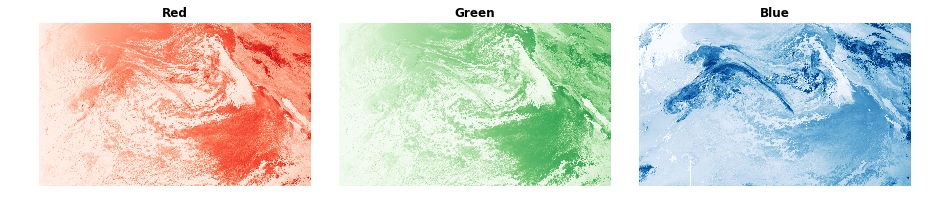

In [7]:
fig, ([ax1, ax2, ax3]) = plt.subplots(1, 3, figsize=(16, 3))

ax1.imshow(R, cmap='Reds', vmax=1, vmin=0)
ax1.set_title('Red', fontweight='semibold')
ax1.axis('off')

ax2.imshow(G, cmap='Greens', vmax=1, vmin=0)
ax2.set_title('Green', fontweight='semibold')
ax2.axis('off')

ax3.imshow(B, cmap='Blues', vmax=1, vmin=0)
ax3.set_title('Blue', fontweight='semibold')
ax3.axis('off')

plt.subplots_adjust(wspace=.02)

The addition of the three channels results in a color image. We combine the
three channels in a stacked array and display the image with `imshow` again.

In [8]:
# For fun, lets get the True Color RGB
def get_TrueColor_RGB():
    R = C['CMI_C02'].data
    G = C['CMI_C03'].data
    B = C['CMI_C01'].data

    # Apply range limits for each channel. RGB values must be between 0 and 1
    R = np.clip(R, 0, 1)
    G = np.clip(G, 0, 1)
    B = np.clip(B, 0, 1)

    # Apply a gamma correction to the image
    gamma = 2.2
    R = np.power(R, 1/gamma)
    G = np.power(G, 1/gamma)
    B = np.power(B, 1/gamma)

    # Calculate the "True" Green
    G_true = 0.45 * R + 0.1 * G + 0.45 * B
    G_true = np.maximum(G_true, 0)
    G_true = np.minimum(G_true, 1)

    return np.dstack([R, G_true, B])

RGB_true = get_TrueColor_RGB()

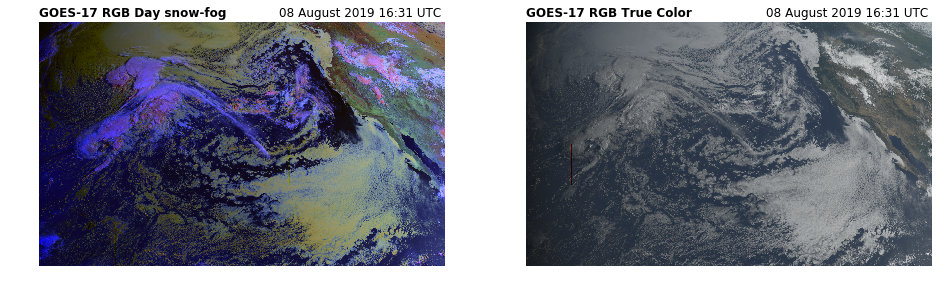

In [9]:
# The RGB array for the true color image
RGB = np.dstack([R, G, B])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

ax1.imshow(RGB)
ax1.set_title('GOES-17 RGB Day snow-fog', fontweight='semibold', loc='left', fontsize=12);
ax1.set_title('%s' % scan_start.strftime('%d %B %Y %H:%M UTC '), loc='right');
ax1.axis('off');

ax2.imshow(RGB_true)
ax2.set_title('GOES-17 RGB True Color', fontweight='semibold', loc='left', fontsize=12);
ax2.set_title('%s' % scan_start.strftime('%d %B %Y %H:%M UTC '), loc='right');
ax2.axis('off');

# Plot with `Cartopy`:  Geostationary Projection
 
The image above is not georeferenced. You can see the land and oceans, but we
do have enough information to draw state and country boundaries. From the
GOES-17 file, we can extract all the metadata needed to understand the map
projection. We will use this data to plot the image on a `Cartopy`. The image
is in a [geostationary
projection](https://proj4.org/operations/projections/geos.html?highlight=geostationary).

In [10]:
C['goes_imager_projection']

######################################################################
#

# Satellite height
sat_h = C['goes_imager_projection'].perspective_point_height

# Satellite longitude
sat_lon = C['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
sat_sweep = C['goes_imager_projection'].sweep_angle_axis

semi_major = C['goes_imager_projection'].semi_major_axis
semi_minor = C['goes_imager_projection'].semi_minor_axis

# The projection x and y coordinates equals the scanning angle (in radians)
# multiplied by the satellite height See details here:
# https://proj4.org/operations/projections/geos.html?highlight=geostationary
x = C['x'][:] * sat_h
y = C['y'][:] * sat_h

The geostationary projection is the easiest way to plot the image on a
map. Essentially, we are stretching the image across a map with the same
projection and dimensions as the data.

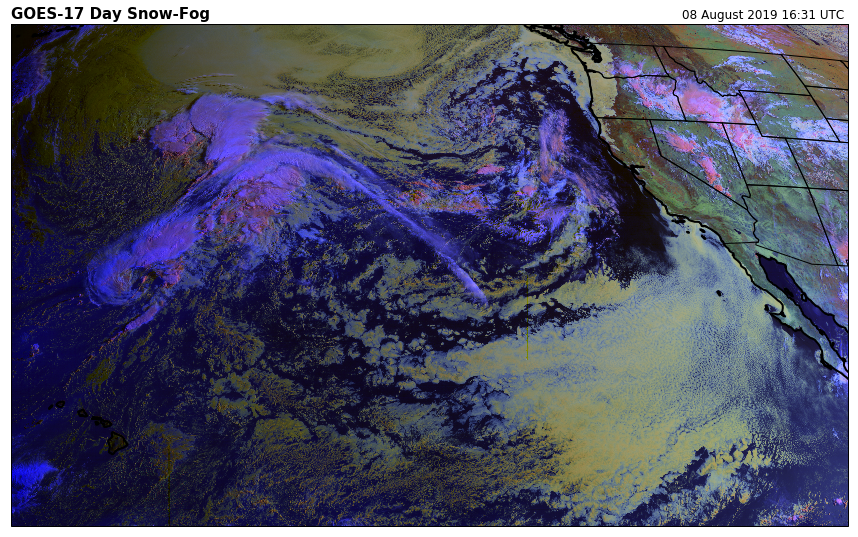

In [11]:
fig = plt.figure(figsize=(15, 12))

globe = ccrs.Globe(semimajor_axis=semi_major, semiminor_axis=semi_minor)
geos = ccrs.Geostationary(central_longitude=sat_lon, 
                         satellite_height=sat_h, globe=globe)

ax = fig.add_subplot(1, 1, 1, projection=geos)

ax.imshow(RGB, origin='upper',
                   extent=(x.min(), x.max(), y.min(), y.max()),
                   transform=geos,
                   interpolation='nearest', vmin=162., vmax=330.)
ax.coastlines(resolution='50m', color='black', linewidth=2)
ax.add_feature(ccrs.cartopy.feature.STATES)

plt.title('GOES-17 Day Snow-Fog', loc='left', fontweight='semibold', fontsize=15)
plt.title('%s' % scan_start.strftime('%d %B %Y %H:%M UTC '), loc='right');

Zoom up on the Bay area...

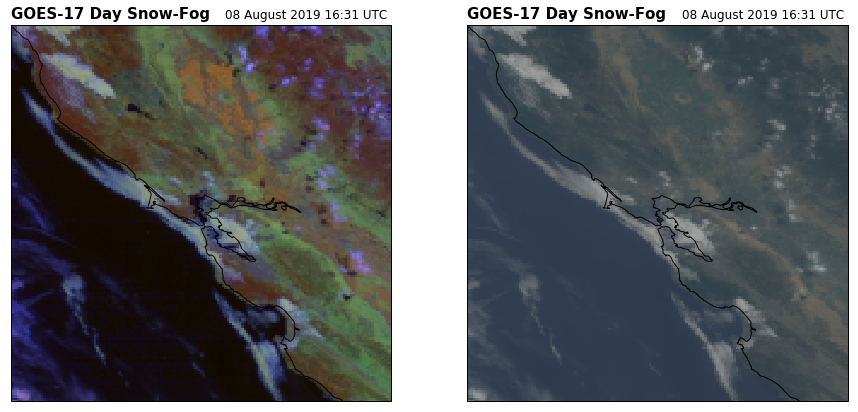

In [18]:
fig = plt.figure(figsize=(15, 12))

globe = ccrs.Globe(semimajor_axis=semi_major, semiminor_axis=semi_minor)
geos = ccrs.Geostationary(central_longitude=sat_lon, 
                         satellite_height=sat_h, globe=globe)

ax1 = fig.add_subplot(1, 2, 1, projection=geos)
ax2 = fig.add_subplot(1, 2, 2, projection=geos)

ax1.imshow(RGB, origin='upper',
                   extent=(x.min(), x.max(), y.min(), y.max()),
                   transform=geos,
                   interpolation='nearest', vmin=162., vmax=330.)
ax1.coastlines(resolution='10m', color='black', linewidth=1)
#ax1.add_feature(ccrs.cartopy.feature.STATES)

ax1.set_title('GOES-17 Day Snow-Fog', loc='left', fontweight='semibold', fontsize=15)
ax1.set_title('%s' % scan_start.strftime('%d %B %Y %H:%M UTC '), loc='right');

ax1.set_extent([-124, -121, 36, 40], crs=ccrs.PlateCarree())

ax2.imshow(RGB_true, origin='upper',
                   extent=(x.min(), x.max(), y.min(), y.max()),
                   transform=geos,
                   interpolation='nearest', vmin=162., vmax=330.)
ax2.coastlines(resolution='10m', color='black', linewidth=1)
#ax2.add_feature(ccrs.cartopy.feature.STATES)

ax2.set_title('GOES-17 Day Snow-Fog', loc='left', fontweight='semibold', fontsize=15)
ax2.set_title('%s' % scan_start.strftime('%d %B %Y %H:%M UTC '), loc='right');

ax2.set_extent([-124, -121, 36, 40], crs=ccrs.PlateCarree())